In [247]:
# Necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

In [248]:
df = pd.read_csv('./Crop_Recommendation.csv')
print(df.iloc[400: 405])

     Nitrogen  Phosphorus  Potassium  Temperature   Humidity  pH_Value  \
400         3          72         24    36.512684  57.928872  6.031608   
401        40          59         23    36.891637  62.731782  5.269085   
402        33          73         23    29.235405  59.389676  5.985793   
403        27          57         24    27.335349  43.357960  6.091863   
404        10          79         18    21.064368  55.469859  5.624731   

       Rainfall        Crop  
400  122.653969  PigeonPeas  
401  163.726655  PigeonPeas  
402  103.330180  PigeonPeas  
403  142.330368  PigeonPeas  
404  184.622671  PigeonPeas  


In [249]:
# Predefined crop list

CROPS = ['Rice', 'Maize', 'ChickPea', 'KidneyBeans', 'PigeonPeas', 'MothBeans', 'MungBean', 
         'Blackgram', 'Lentil', 'Pomegranate', 'Banana', 'Mango', 'Grapes', 'Watermelon', 
         'Muskmelon', 'Apple', 'Orange', 'Papaya', 'Coconut', 'Cotton', 'Jute', 'Coffee']

In [250]:
def preprocess_dataframe(df):

    # Create a copy of the dataframe
    processed_df = df.copy()
    
    # Encode Crop column using predefined CROPS list
    if 'Crop' in processed_df.columns:
        processed_df['Crop'] = processed_df['Crop'].apply(lambda x: CROPS.index(x))
    else:
        raise ValueError("'Crop' column not found in the dataset")
    
    # Separate features and target (assuming 'Crop' is the target)
    X = processed_df.drop(columns=['Crop'])
    y = processed_df['Crop']
    
    # Convert all features to numeric
    numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
    non_numeric_columns = X.select_dtypes(exclude=['int64', 'float64']).columns
    
    # Handle any remaining non-numeric columns
    for col in non_numeric_columns:
        X[col] = pd.Categorical(X[col]).codes
    
    # Convert to numeric type
    X = X.apply(pd.to_numeric, errors='coerce')
    
    # Impute any missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    return X_imputed, y, CROPS

In [251]:
def train_classification_model(X_train, X_test, y_train, y_test, crop_labels):

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = clf.predict(X_test_scaled)
    
    # Classification Report with crop names
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=crop_labels))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=crop_labels, yticklabels=crop_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Feature Importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': clf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return clf, scaler, crop_labels

In [256]:
def manual_predict(scaler, clf, input_data):
    """
    Manually predict crop for given input data with pie chart visualization
    """
    # Convert input to DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Scale the input data
    input_scaled = scaler.transform(input_df)
    
    # Predict
    prediction = clf.predict(input_scaled)
    prediction_proba = clf.predict_proba(input_scaled)
    
    # Get the predicted crop
    predicted_crop_index = prediction[0]
    predicted_crop = CROPS[predicted_crop_index]
    
    # Get probabilities for top 3 predictions
    top_3_indices = prediction_proba[0].argsort()[-3:][::-1]
    top_3_probs = prediction_proba[0][top_3_indices]
    top_3_crops = [CROPS[idx] for idx in top_3_indices]


    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(top_3_probs,
            labels=top_3_crops,
            autopct='%1.1f%%',
            startangle=140,
            colors=['#ff9999','#66b3ff','#99ff99'],
            explode=[0.1 if i == 0 else 0 for i in range(len(top_3_probs))])
    
    plt.title('Top 3 Predicted Crops Probability Distribution', pad=20)
    plt.axis('equal')  # Equal aspect ratio ensures circular shape
    
    # Add legend
    plt.legend(title="Crops",
               loc="upper right",
               bbox_to_anchor=(1.3, 1))
    
    plt.tight_layout()
    plt.show()
    
    return predicted_crop


Classification Report:
              precision    recall  f1-score   support

        Rice       1.00      0.89      0.94        19
       Maize       1.00      1.00      1.00        21
    ChickPea       1.00      1.00      1.00        26
 KidneyBeans       1.00      1.00      1.00        20
  PigeonPeas       1.00      1.00      1.00        23
   MothBeans       1.00      0.96      0.98        24
    MungBean       1.00      1.00      1.00        19
   Blackgram       1.00      1.00      1.00        20
      Lentil       0.92      1.00      0.96        11
 Pomegranate       1.00      1.00      1.00        23
      Banana       1.00      1.00      1.00        21
       Mango       1.00      1.00      1.00        19
      Grapes       1.00      1.00      1.00        14
  Watermelon       1.00      1.00      1.00        19
   Muskmelon       1.00      1.00      1.00        17
       Apple       1.00      1.00      1.00        23
      Orange       1.00      1.00      1.00        14
   

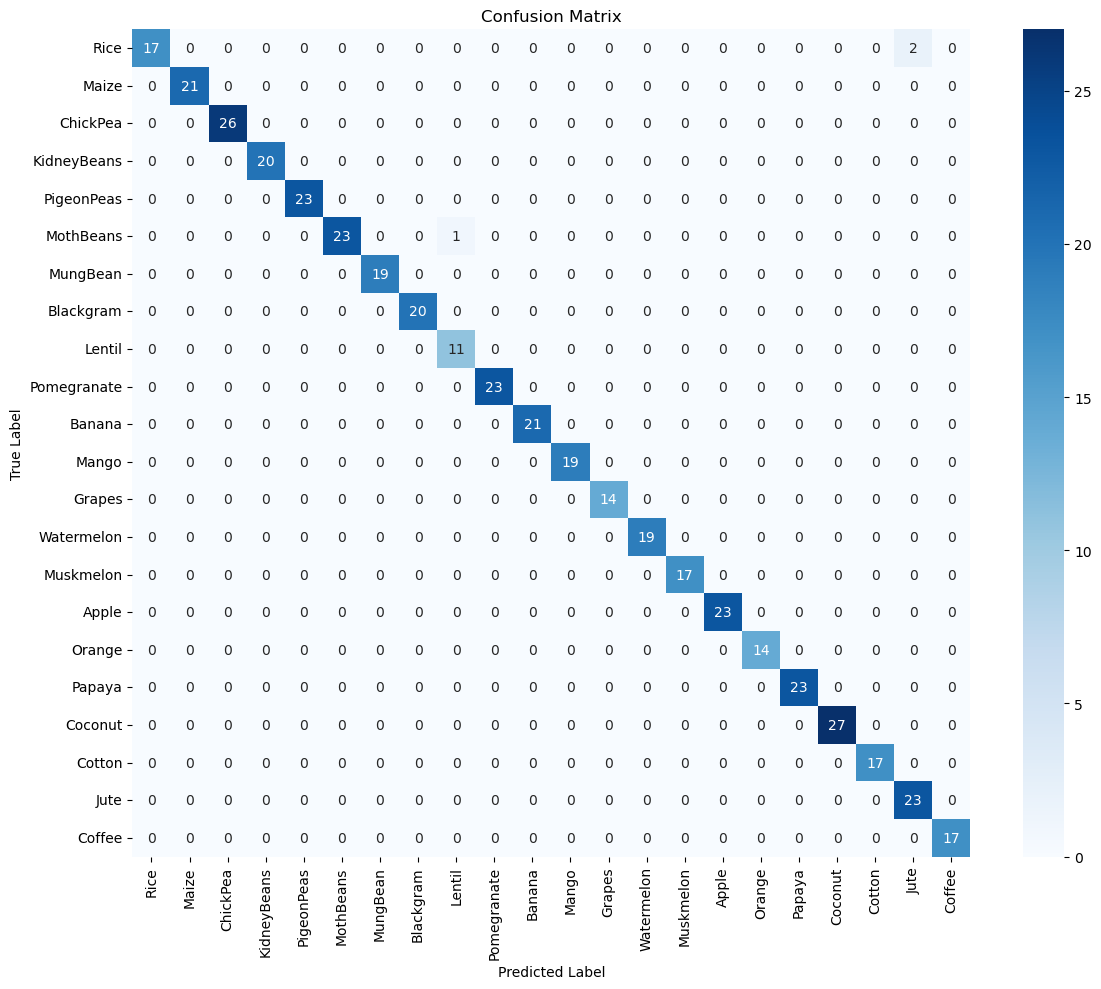

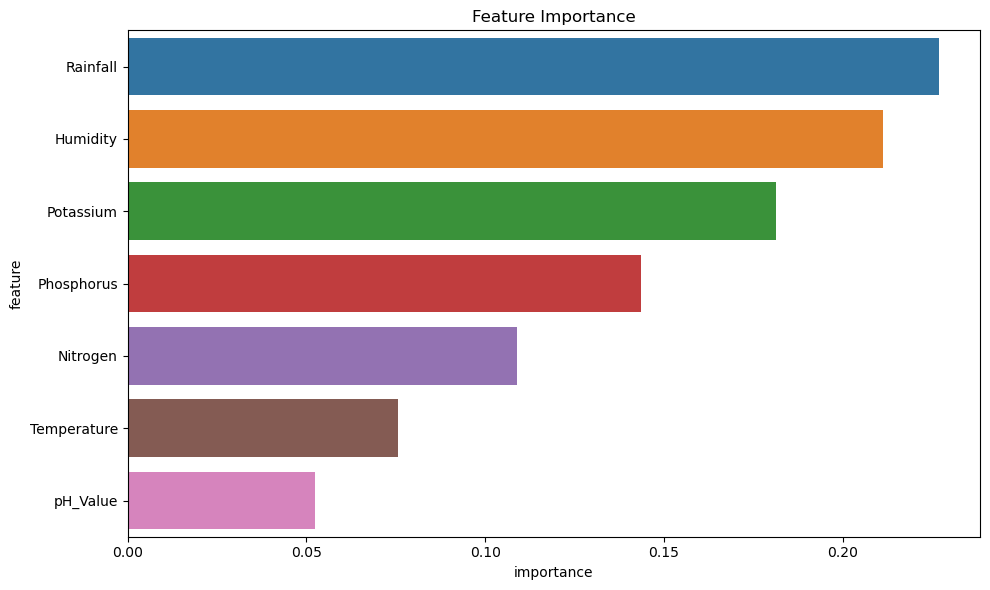

In [257]:
def main(file_path):
    
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Preprocess the data
    X, y, crop_labels = preprocess_dataframe(df)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train the model
    model, scaler, labels = train_classification_model(X_train, X_test, y_train, y_test, crop_labels)
    
    return model, scaler, labels

# Example usage
# Replace with your actual file path
model, scaler, crop_labels = main('./Crop_Recommendation.csv')

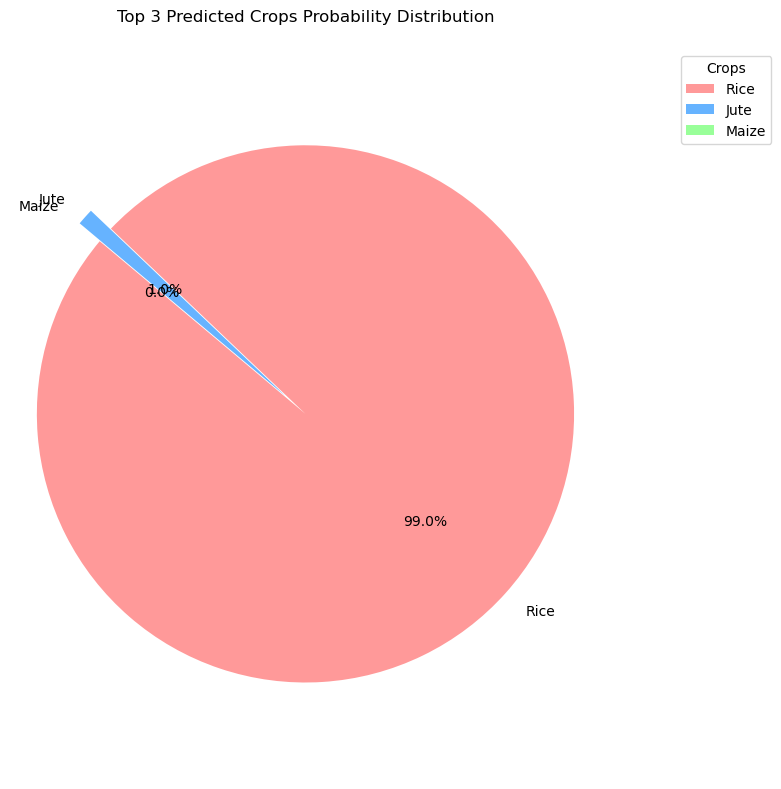

'Rice'

In [258]:
# Example 1

manual_input_example = {
     'Nitrogen': 90,
     'Phosphorus': 42,
     'Potassium': 43,
     'Temperature': 21.1,
     'Humidity': 82.1,
     'pH_Value': 6.5,
     'Rainfall': 202.9
}

manual_predict(scaler, model, manual_input_example)

In [ ]:
# Example 2

manual_input_example = {
     'Nitrogen': 50,
     'Phosphorus': 62,
     'Potassium': 20,
     'Temperature': 32.5,
     'Humidity': 58.51,
     'pH_Value': 5.84,
     'Rainfall': 104.5
}

manual_predict(scaler, model, manual_input_example)